In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from random import randint

%matplotlib inline

# Word2Vec

We want to create words vectors so that our deep learning model will be able to process the text data. 

For simplicity sake, I will be using a pre-trained Word2Vec model to create word vectors for my twitter dataset 

## GloVe
I will be using a pre-trained model, [GloVe](http://nlp.stanford.edu/projects/glove/), which is much more manageable as compared to Google's Word2Vec model. 

GloVe provides a couple of options, and I will use the matrix that contains 400,000 word vectors (each with a dimensionality of 50) for faster training process

In [2]:
wordslist = np.load('C:\\Users\\Ung Lik Teng\\Desktop\\CodenData\\Machine Learning\\NLP\\LSTM-Sentiment-Analysis\\wordsList.npy')
print("Word List successfully loaded.")

wordslist = wordslist.tolist()
wordslist = [word.decode('UTF-8') for word in wordslist]

wordvectors = np.load('C:\\Users\\Ung Lik Teng\\Desktop\\CodenData\\Machine Learning\\NLP\\LSTM-Sentiment-Analysis\\wordVectors.npy')
print("Word Vectors successfully loaded.")


Word List successfully loaded.
Word Vectors successfully loaded.


In [3]:
df_model = pd.read_csv("C:/Users/Ung Lik Teng/Desktop/CodenData/Machine Learning/NLP/cleaned.csv")

In [4]:
num_words = sum(df_model.clean_count_words.values)
num_tweets = df_model.shape[0]
print('Total number of tweets:', num_tweets)
print('Total number of words:', num_words)
print('Average number of words per tweets:', num_words/num_tweets)

Total number of tweets: 99989
Total number of words: 693111
Average number of words per tweets: 6.93187250598


Text(0,0.5,'Frequency')

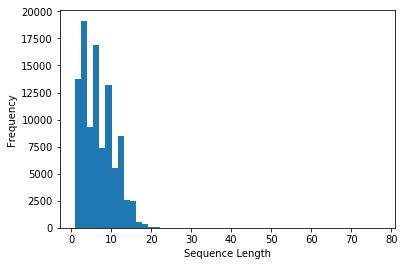

In [5]:
plt.hist(df_model.clean_count_words.values,50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')

Based on the average number of words per tweets and the histogram, it's safe to say most tweets will fall under 10 words after cleaning.

In [6]:
SeqLength = 10

In [7]:
df_small = df_model.sample(200)
df_small = df_small.reset_index(drop=True)
text_only = df_small.clean_text
text_only = text_only.reset_index(drop = True)

In [8]:
text_only = text_only.tolist()

# Creating ids/ Word Vectors for all tweets  

In [9]:
ids = np.zeros((250, 10), dtype = 'int32')

In [10]:
tweet_index = 0

for tweet in text_only:
    seq_index = 0
    for word in tweet.split():
        try:
            ids[tweet_index][seq_index] = wordslist.index(word)
        except ValueError:
            ids[tweet_index][seq_index] = 399999
        seq_index = seq_index + 1
        if seq_index >= SeqLength:
            break
    tweet_index = tweet_index + 1

In [11]:
## Check if ids matrix is created correctly 
ids

array([[ 30632,   7392,    413, ...,      0,      0,      0],
       [  1906, 399999, 399999, ...,    974, 399999, 399999],
       [  2357,    117,  14115, ...,      0,      0,      0],
       ..., 
       [     0,      0,      0, ...,      0,      0,      0],
       [     0,      0,      0, ...,      0,      0,      0],
       [     0,      0,      0, ...,      0,      0,      0]])

In [12]:
df_small.Sentiment.values

array([1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0], dtype=int64)

In [13]:
# Defining Helper functiom 
from random import randint

def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, SeqLength])
    for i in range(batchSize):
        num = randint(1,160)
        if (df_small.Sentiment.values[num-1] == 1):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i-1] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, SeqLength])
    for i in range(batchSize):
        num = randint(161,200)
        if (df_small.Sentiment.values[num-1] == 1):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i-1] = ids[num-1:num]
    return arr, labels

## Building the LSTM Model 

In [14]:
## Defining Hyperparameters 
batchSize = 20
lstmUnits = 64
numClasses = 2
iterations = 100000
learning_rate = 0.001

In [15]:
## Defining Constant
SeqLength = 10
embedding_dim = 50

In [16]:
##Defining Placeholder
labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, SeqLength])

In [17]:
##Defining Data
data = tf.Variable(tf.zeros([batchSize, SeqLength, embedding_dim]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordvectors,input_data)

In [18]:
#Definint LSTM Cell
lstm_cell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstm_cell = tf.contrib.rnn.DropoutWrapper(cell=lstm_cell, output_keep_prob= 0.75)
value, _ = tf.nn.dynamic_rnn(lstm_cell, data, dtype=tf.float32)

In [19]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape= [numClasses]))
value = tf.transpose(value, [1,0,2])
last = tf.gather(value, int(value.get_shape()[0])-1)
prediction = (tf.matmul(last,weight)+ bias)

In [20]:
correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

In [22]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = prediction, labels= labels))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [23]:
sess = tf.InteractiveSession()

In [24]:
sess.run(tf.global_variables_initializer())

for i in range(iterations):
    #Next Batch of reviews
    nextBatch, nextBatchLabels = getTrainBatch();
    sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})   

In [27]:
sess.run(tf.global_variables_initializer())
iterations = 10
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Accuracy for this batch:", (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)

Accuracy for this batch: 64.9999976158
Accuracy for this batch: 64.9999976158
Accuracy for this batch: 40.000000596
Accuracy for this batch: 69.9999988079
Accuracy for this batch: 60.0000023842
Accuracy for this batch: 75.0
Accuracy for this batch: 64.9999976158
Accuracy for this batch: 85.0000023842
Accuracy for this batch: 64.9999976158
Accuracy for this batch: 50.0
